In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
from torch import nn
import torch
from torch.nn import Sequential, LSTM, Linear
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
tsm_data = pd.read_csv("TSM.csv").set_index("Date")
tsm_close = tsm_data[['Adj Close']]
print(tsm_close.describe())
print("====================================")
print(tsm_close.info())

         Adj Close
count  2518.000000
mean     48.100123
std      34.363482
min      11.935702
25%      18.799965
50%      34.418303
75%      77.987217
max     136.403519
<class 'pandas.core.frame.DataFrame'>
Index: 2518 entries, 2013-07-01 to 2023-06-30
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2518 non-null   float64
dtypes: float64(1)
memory usage: 39.3+ KB
None


Text(0.5, 1.0, 'Closing Price of TSM Adj Close')

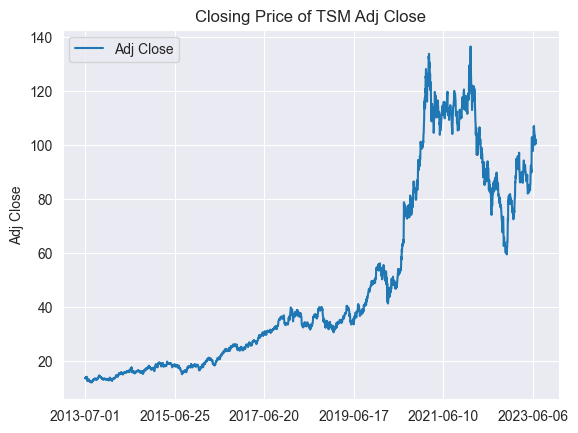

In [4]:
tsm_close.plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title(f"Closing Price of TSM Adj Close")

Date
2013-07-01     13.602425
2013-07-02     13.639286
2013-07-03     13.731743
2013-07-05     13.799943
2013-07-08     13.337674
                 ...    
2023-06-26    100.110001
2023-06-27    102.080002
2023-06-28    100.919998
2023-06-29    100.639999
2023-06-30    100.919998
Name: Adj Close, Length: 2518, dtype: float64


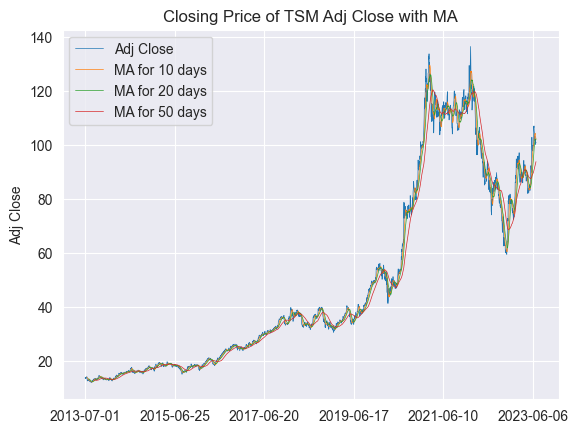

In [5]:
ma_day = [10, 20, 50]

tsm_close_with_ma = tsm_close.copy()
print(tsm_close_with_ma["Adj Close"])

for ma in ma_day:
    column_name = f"MA for {ma} days"
    tsm_close_with_ma[column_name] = tsm_close_with_ma['Adj Close'].rolling(ma).mean()

tsm_close_with_ma.plot(linewidth=0.5)
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title(f"Closing Price of TSM Adj Close with MA")
plt.savefig("Closing Price of TSM Adj Close with MA.png", dpi=600)

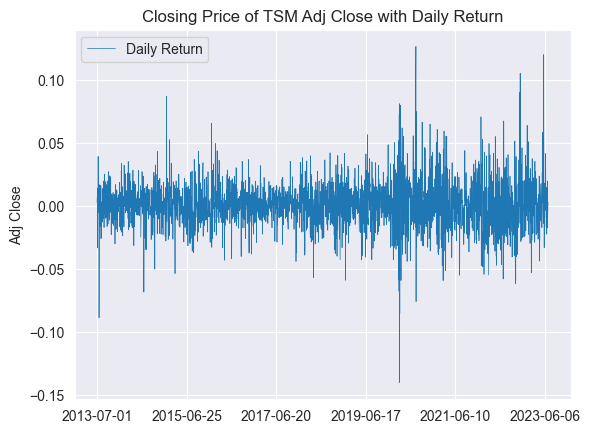

In [6]:
tsm_close_ma_return = tsm_close_with_ma
tsm_close_ma_return['Daily Return'] = tsm_close_ma_return['Adj Close'].pct_change()

tsm_close_ma_return[['Daily Return']].plot(linewidth=0.5)
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title(f"Closing Price of TSM Adj Close with Daily Return")
plt.savefig("Closing Price of TSM Adj Close with Daily Return.png", dpi=600)

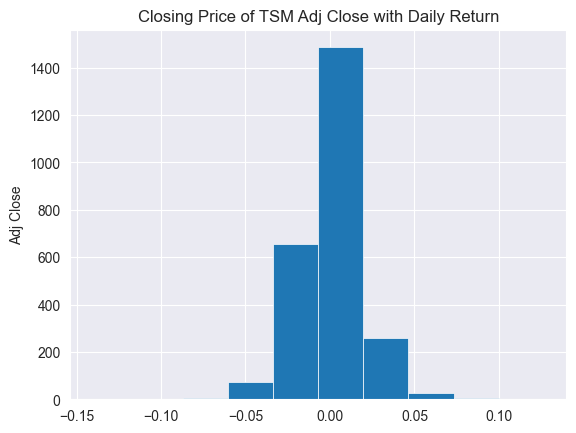

In [7]:
tsm_close_ma_return[['Daily Return']].hist(linewidth=0.5)
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title(f"Closing Price of TSM Adj Close with Daily Return")
plt.savefig("Closing Price of TSM Adj Close with Daily Return.png", dpi=600)

In [8]:
dataset = tsm_close.values
print(dataset)
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))
training_data_len

[[ 13.60242462]
 [ 13.63928604]
 [ 13.73174286]
 ...
 [100.91999817]
 [100.63999939]
 [100.91999817]]


2393

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
print(scaled_data)

[[0.01339079]
 [0.01368694]
 [0.01442976]
 ...
 [0.71491811]
 [0.71266854]
 [0.71491811]]


In [10]:
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train)

[[[0.01339079]
  [0.01368694]
  [0.01442976]
  ...
  [0.00949805]
  [0.01156814]
  [0.01102019]]

 [[0.01368694]
  [0.01442976]
  [0.01497769]
  ...
  [0.01156814]
  [0.01102019]
  [0.00955893]]

 [[0.01442976]
  [0.01497769]
  [0.01126373]
  ...
  [0.01102019]
  [0.00955893]
  [0.00955893]]

 ...

 [[0.44671754]
  [0.45217853]
  [0.48035372]
  ...
  [0.51808357]
  [0.50327933]
  [0.50017523]]

 [[0.45217853]
  [0.48035372]
  [0.49357082]
  ...
  [0.50327933]
  [0.50017523]
  [0.49563846]]

 [[0.48035372]
  [0.49357082]
  [0.49254191]
  ...
  [0.50017523]
  [0.49563846]
  [0.48560974]]]


In [11]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2333/2333 [==============================] - 31s 13ms/step - loss: 0.0018


In [12]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

4/4 [==============================] - 0s 10ms/step


In [13]:
# Plot the data
train = tsm_close[:training_data_len]
valid = tsm_close[training_data_len:]
valid['Predictions'] = predictions
valid = valid._append(train)
valid = valid.sort_index(ascending=True)
print(valid)


             Adj Close  Predictions
Date                               
2013-07-01   13.602425          NaN
2013-07-02   13.639286          NaN
2013-07-03   13.731743          NaN
2013-07-05   13.799943          NaN
2013-07-08   13.337674          NaN
...                ...          ...
2023-06-26  100.110001   103.021812
2023-06-27  102.080002   102.210358
2023-06-28  100.919998   101.760880
2023-06-29  100.639999   101.365982
2023-06-30  100.919998   101.034264

[2518 rows x 2 columns]


C:\Users\Xunhaoz\AppData\Local\Temp\ipykernel_16244\860708771.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


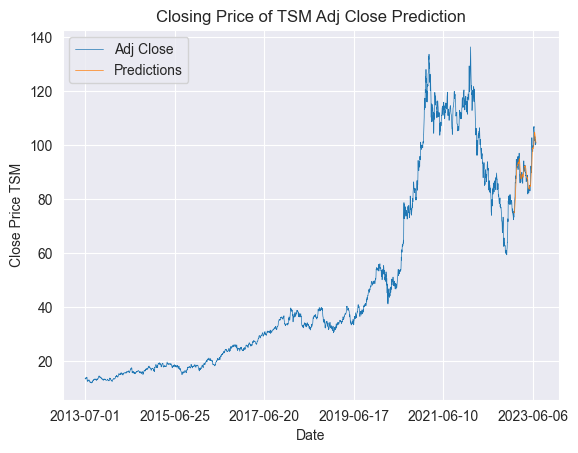

In [14]:
valid.plot(linewidth=0.5)
plt.ylabel('Close Price TSM')
plt.title(f"Closing Price of TSM Adj Close Prediction")
plt.savefig("Closing Price of TSM Adj Close Prediction.png", dpi=600)

In [15]:
valid

,Adj Close,Predictions
Date,,
2013-07-01,13.602425,NaN
2013-07-02,13.639286,NaN
2013-07-03,13.731743,NaN
2013-07-05,13.799943,NaN
2013-07-08,13.337674,NaN
...,...,...
2023-06-26,100.110001,103.021812
2023-06-27,102.080002,102.210358
2023-06-28,100.919998,101.760880
